In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#data_old = pd.read_csv('corona_tested_individuals_ver_006.english.csv', low_memory = False)
data_new = pd.read_csv('corona_tested_individuals_ver_00220.english.csv', low_memory = False)
data = data_new

## Preprocess

In [3]:
# drop stuff
data.drop(data[data.corona_result=='other'].index, inplace=True)
data.dropna(inplace=True)
data.drop('test_date', axis=1, inplace=True)

# encode
result_code = {'negative': 0, 'positive': 1}
above60_code = {'No': 0, 'Yes': 1}
gender_code = {'female': 0, 'male': 1}
data.gender = data.gender.map(gender_code)
data.age_60_and_above = data.age_60_and_above.map(above60_code)
data.corona_result = data.corona_result.map(result_code)

data = pd.get_dummies(data, columns=["test_indication"])

## Train-test split

In [4]:
x = data.drop('corona_result', axis=1)
y = data.corona_result

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

## Chi2 feature selection

In [5]:
def get_Chi2_feature_importance(x_train, y_train):
    # fit model
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(x_train, y_train)

    # plot feature importance scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xticks(range(0,10), x_train.columns, rotation='vertical')
    plt.title('Ch2 Feature Importances')
    plt.show()

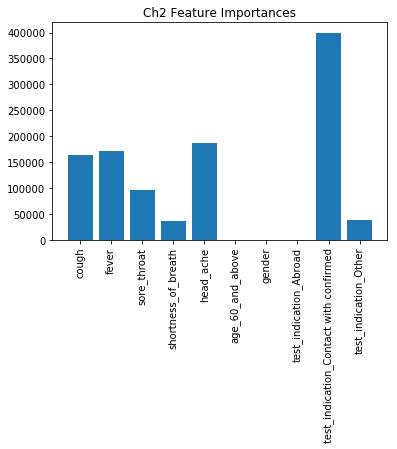

In [6]:
get_Chi2_feature_importance(X_train, y_train)

## Random Forest

In [7]:

def classify_with_RF(x_train, x_test, y_train, y_test):
    RF = RandomForestClassifier()
    RF.fit(x_train, y_train)

    y_pred = RF.predict(x_test)

    # print scores
    print(classification_report(y_pred, y_test))
    print(roc_auc_score(y_pred, y_test))
    
    #plot feature importances
    importances = RF.feature_importances_
    plt.bar([i for i in range(len(importances))], importances)
    plt.xticks(range(0,10), x_train.columns, rotation='vertical')
    plt.title('Random Forest Feature Importances')
    plt.show()

    return RF

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    654102
           1       0.02      0.53      0.04      2586

    accuracy                           0.89    656688
   macro avg       0.51      0.71      0.49    656688
weighted avg       0.99      0.89      0.94    656688

0.7073901750893048


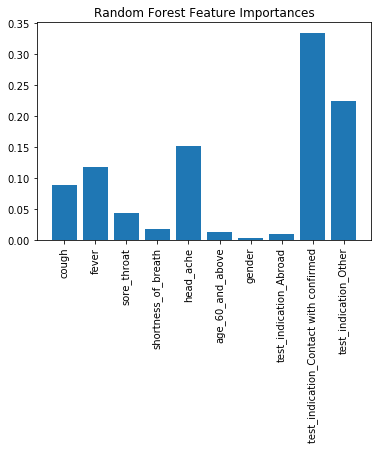

In [8]:
RF = classify_with_RF(X_train, X_test, y_train, y_test)

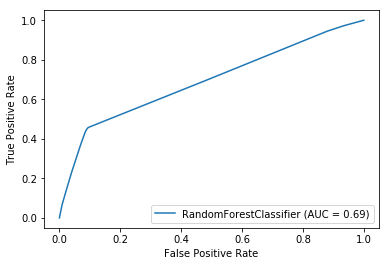

In [9]:
plot_roc_curve(RF, X_test, y_test)

## Random Forest with undersampling - class imbalance

In [10]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92    566747
           1       0.46      0.38      0.42     89941

    accuracy                           0.85    656688
   macro avg       0.68      0.66      0.67    656688
weighted avg       0.84      0.85      0.85    656688

0.6556454677309884


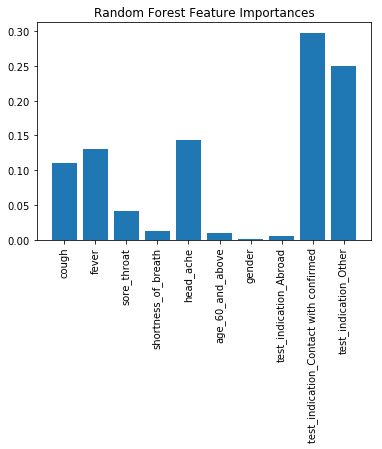

In [11]:
RFU = classify_with_RF(X_under, X_test, y_under, y_test)

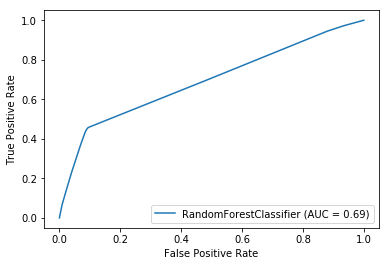

In [12]:
plot_roc_curve(RF, X_test, y_test)